In [2]:
# ==============================================================================
# CELDA 1: INSTALACIÓN Y PREPARACIÓN (VERSIÓN CORREGIDA Y MÁS ROBUSTA)
# ==============================================================================

# Instalar la librería para análisis geoespacial
!pip install geopandas

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf
import os

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- Cargar los datos ---
print("Intentando cargar los archivos directamente desde la sesión de Colab...")

try:
    # Cargar precios (sabemos que la columna es 'Date')
    prices_df = pd.read_csv('prices_with_metrics.csv', parse_dates=['Date'])

    # Cargar los otros archivos sin parsear fechas inicialmente para poder inspeccionarlos
    trends_df = pd.read_csv('trends_enriched.csv')
    integrated_df = pd.read_csv('integrated_data.csv')
    country_agg_df = pd.read_csv('country_aggregated.csv')
    geo_countries_path = 'geo_countries.geojson'

    # --- Depuración: Inspeccionar las columnas para verificar los nombres ---
    print("\nColumnas del archivo 'trends_enriched.csv':")
    print(trends_df.columns)
    print("\nColumnas del archivo 'integrated_data.csv':")
    print(integrated_df.columns)

    # --- Conversión de Fechas ---
    # El error sugiere que la columna 'date' no existe. Vamos a manejarlo.
    # El nombre correcto probablemente es 'Date' (con mayúscula).
    # Este código lo manejará y renombrará para que el resto del script funcione.

    # Para trends_df
    if 'date' in trends_df.columns:
        trends_df['date'] = pd.to_datetime(trends_df['date'])
    elif 'Date' in trends_df.columns:
        trends_df['Date'] = pd.to_datetime(trends_df['Date'])
        trends_df.rename(columns={'Date': 'date'}, inplace=True) # Renombrar para consistencia
    else:
        raise KeyError("No se encontró una columna de fecha ('date' o 'Date') en trends_enriched.csv")

    # Para integrated_df
    if 'date' in integrated_df.columns:
        integrated_df['date'] = pd.to_datetime(integrated_df['date'])
    elif 'Date' in integrated_df.columns:
        integrated_df['Date'] = pd.to_datetime(integrated_df['Date'])
        integrated_df.rename(columns={'Date': 'date'}, inplace=True) # Renombrar para consistencia
    else:
        raise KeyError("No se encontró una columna de fecha ('date' o 'Date') en integrated_data.csv")

    print("\n✅ ¡Datos cargados y fechas convertidas exitosamente!")
    print("\nPrevisualización de datos de precios:")
    print(prices_df.head())
    print("\nPrevisualización de datos integrados (con columna 'date' corregida):")
    print(integrated_df.head())

except FileNotFoundError as e:
    print(f"\n❌ Error de Archivo no Encontrado: No se pudo localizar el archivo '{e.filename}'.")
    print("Por favor, asegúrate de haber subido todos los archivos CSV y el .geojson a la sesión de Google Colab.")
except KeyError as e:
    print(f"\n❌ Error de Columna: {e}")
    print("Revisa los nombres de las columnas impresos arriba y ajusta el código si es necesario.")

Intentando cargar los archivos directamente desde la sesión de Colab...

Columnas del archivo 'trends_enriched.csv':
Index(['date', 'country', 'keyword', 'interest', 'country_code', 'iso3',
       'name', 'region', 'lon', 'lat'],
      dtype='object')

Columnas del archivo 'integrated_data.csv':
Index(['Date', 'country', 'crypto', 'interest', 'country_code', 'iso3', 'name',
       'region', 'lon', 'lat', 'Open', 'High', 'Low', 'Close', 'Volume',
       'returns', 'log_returns', 'volatility_7d', 'volatility_30d',
       'returns_squared', 'price_normalized'],
      dtype='object')

✅ ¡Datos cargados y fechas convertidas exitosamente!

Previsualización de datos de precios:
        Date crypto       Open       High        Low      Close     Volume  \
0 2020-10-12    BNB  28.549908  31.082113  28.491446  30.714682  718406691   
1 2020-10-13    BNB  30.670006  31.765100  30.269403  30.706745  600050050   
2 2020-10-14    BNB  30.738811  31.297539  30.461908  30.912119  460297911   
3 2020-1

--- Test de Paseo Aleatorio (ADF) para precios de Bitcoin ---
ADF Statistic: -0.5948304880010945
p-value: 0.8721458514222445
Resultado: Dado que el p-value es > 0.05, no podemos rechazar la hipótesis nula. La serie de precios parece ser un paseo aleatorio.

--- Gráficos de Autocorrelación (ACF) ---


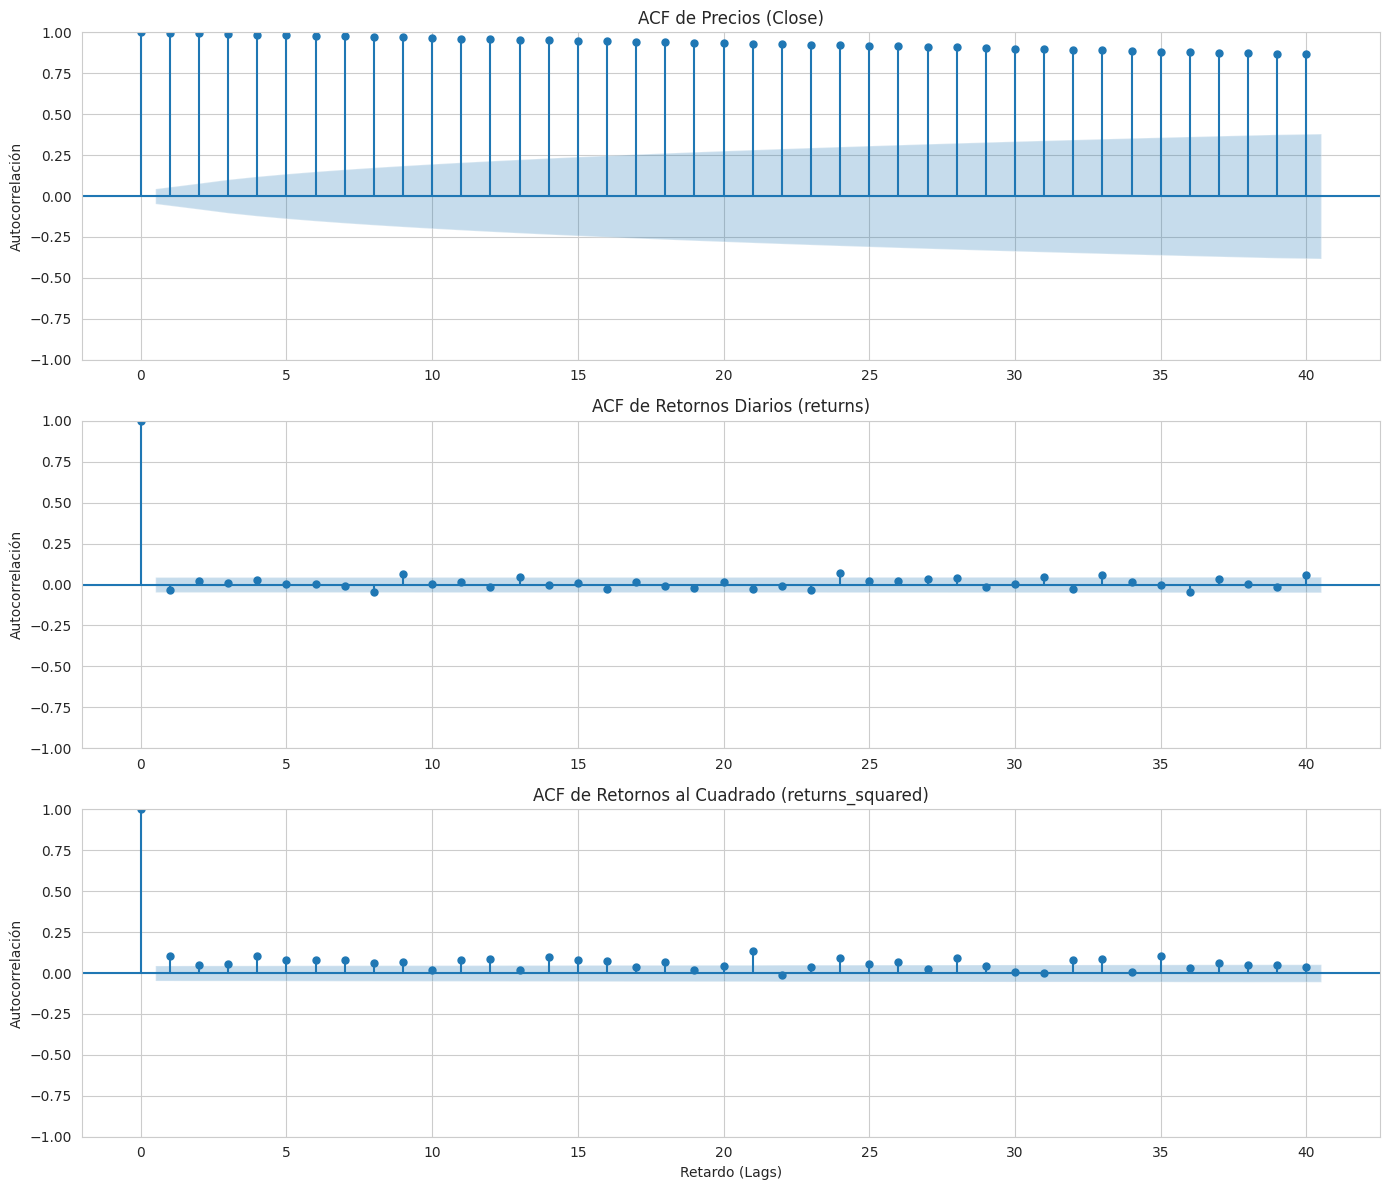


--- Visualización de Volatility Clustering ---


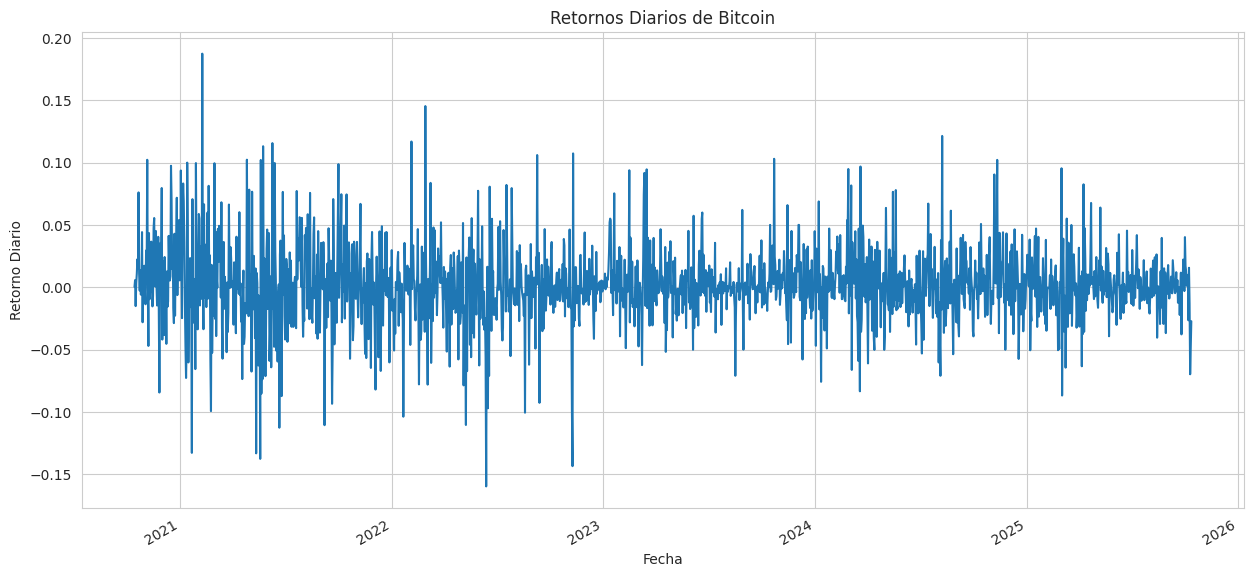

Observa cómo los períodos de grandes cambios (positivos o negativos) tienden a agruparse. Esto es 'volatility clustering'.


In [3]:
# ==============================================================================
# CELDA 2: ANÁLISIS DE SERIES DE TIEMPO (BITCOIN)
# ==============================================================================

# Filtrar datos solo para Bitcoin para el análisis de series de tiempo
btc_df = prices_df[prices_df['crypto'] == 'Bitcoin'].set_index('Date').dropna()

# --- 1.1 Test de Paseo Aleatorio (Augmented Dickey-Fuller Test) ---
# La hipótesis nula es que la serie tiene una raíz unitaria (no es estacionaria, como un Random Walk)
adf_test = adfuller(btc_df['Close'])
print('--- Test de Paseo Aleatorio (ADF) para precios de Bitcoin ---')
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('Resultado: Dado que el p-value es > 0.05, no podemos rechazar la hipótesis nula. La serie de precios parece ser un paseo aleatorio.\n')


# --- 1.2 Análisis de Autocorrelación (ACF) ---
print('--- Gráficos de Autocorrelación (ACF) ---')
# Gráfico 1: ACF de los Precios de Cierre
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_acf(btc_df['Close'], lags=40, ax=axes[0], title='ACF de Precios (Close)')
axes[0].set_ylabel("Autocorrelación")

# Gráfico 2: ACF de los Retornos Diarios
plot_acf(btc_df['returns'], lags=40, ax=axes[1], title='ACF de Retornos Diarios (returns)')
axes[1].set_ylabel("Autocorrelación")

# Gráfico 3: ACF de los Retornos al Cuadrado (Proxy de Volatilidad)
plot_acf(btc_df['returns_squared'], lags=40, ax=axes[2], title='ACF de Retornos al Cuadrado (returns_squared)')
axes[2].set_ylabel("Autocorrelación")
axes[2].set_xlabel("Retardo (Lags)")

plt.tight_layout()
plt.show()

# --- 1.3 Volatilidad y Clustering ---
print('\n--- Visualización de Volatility Clustering ---')
btc_df['returns'].plot(title='Retornos Diarios de Bitcoin', legend=None)
plt.ylabel('Retorno Diario')
plt.xlabel('Fecha')
plt.show()
print("Observa cómo los períodos de grandes cambios (positivos o negativos) tienden a agruparse. Esto es 'volatility clustering'.")

In [4]:
# ==============================================================================
# CELDA 3: MAPA COROPLÉTICO DE INTERÉS GLOBAL
# ==============================================================================

# Calcular el interés promedio por país
avg_interest_by_country = trends_df.groupby('country')['interest'].mean().reset_index()

# Crear el mapa coroplético
fig = px.choropleth(
    avg_interest_by_country,
    locations="country",
    locationmode='country names',
    color="interest",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Interés Promedio Global de Búsqueda de Criptomonedas"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Fuente: Google Trends',
        showarrow = False
    )]
)

fig.show()

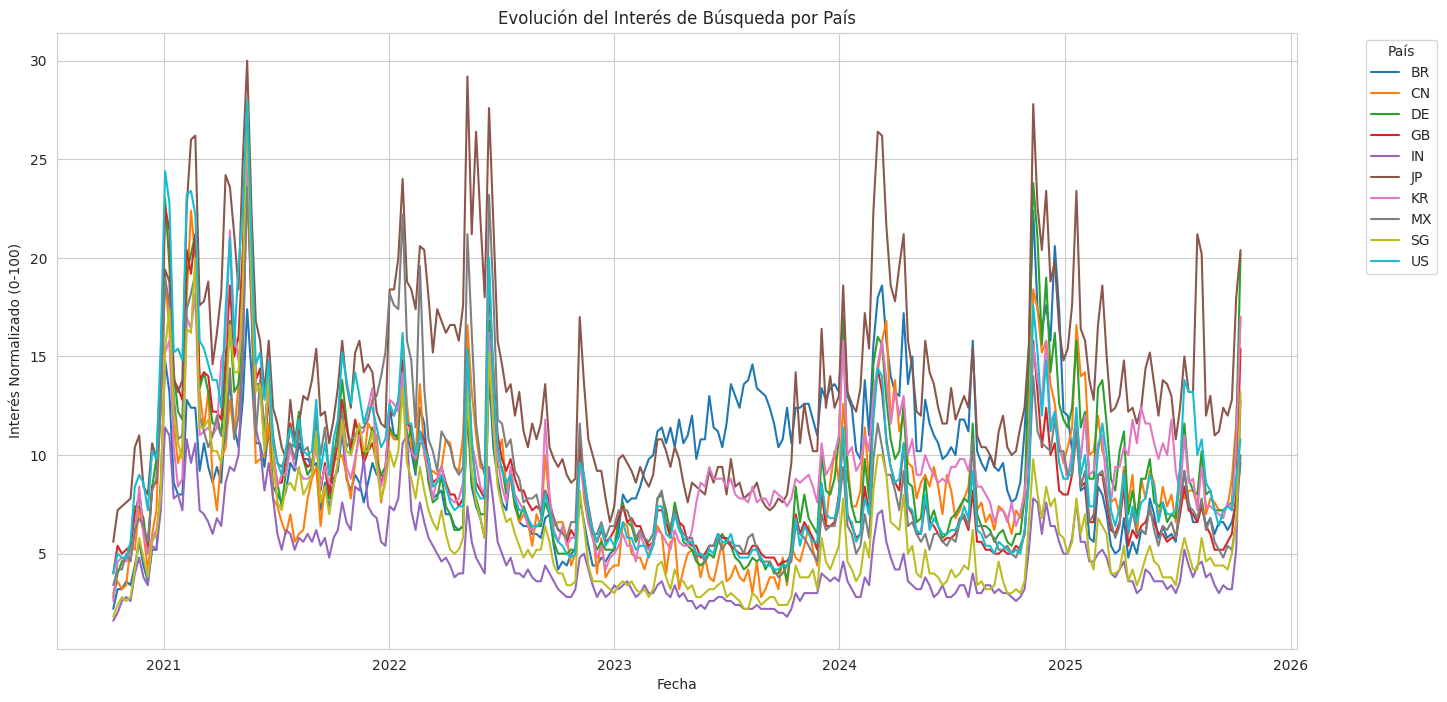

In [5]:
# ==============================================================================
# CELDA 4: SERIES DE TIEMPO DE INTERÉS POR REGIÓN
# ==============================================================================

# Agrupar por fecha y país para obtener el interés promedio diario por país
interest_by_region = trends_df.groupby(['date', 'country'])['interest'].mean().reset_index()

# Graficar la serie de tiempo con Seaborn
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=interest_by_region,
    x='date',
    y='interest',
    hue='country'
)
plt.title('Evolución del Interés de Búsqueda por País')
plt.ylabel('Interés Normalizado (0-100)')
plt.xlabel('Fecha')
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

--- Correlación entre Interés Global y Volatilidad de Bitcoin ---
La correlación de Pearson es: 0.4712

--- Gráfico de Correlación Cruzada (CCF) ---


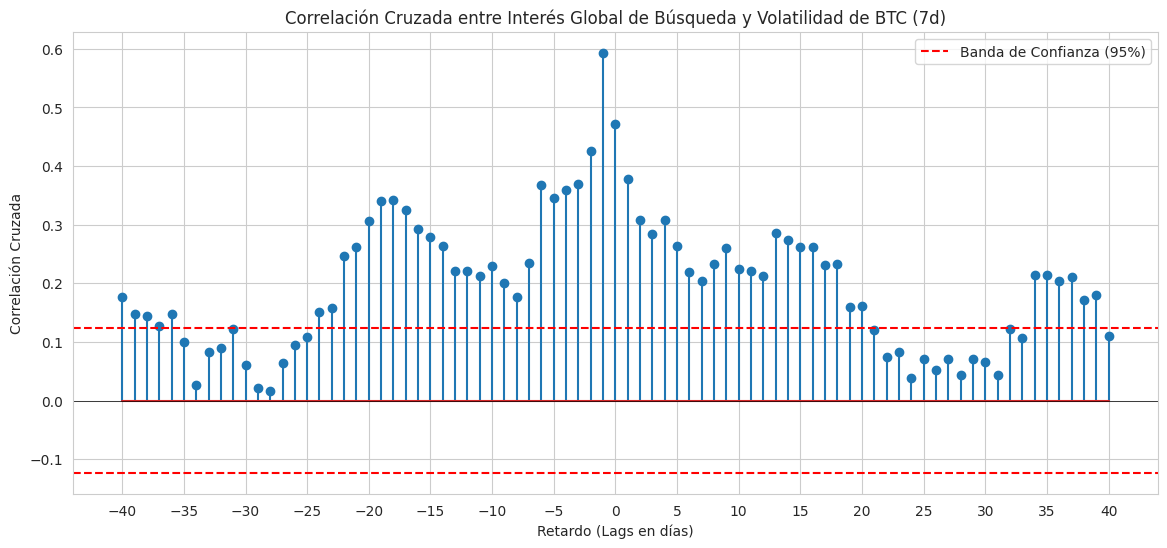


Interpretación del gráfico:
- Eje X: 'Lags' en días. Un lag negativo significa que el interés adelanta a la volatilidad.
- Eje Y: La fuerza de la correlación.
- Líneas rojas: Si las barras superan estas líneas, la correlación es estadísticamente significativa.

Analiza dónde se encuentran los picos más altos para determinar la relación de adelanto o rezago.



In [8]:
# ==============================================================================
# CELDA 5: ANÁLISIS DE CORRELACIÓN CRUZADA (CCF) (VERSIÓN FINAL)
# ==============================================================================

# Preparar los datos para el análisis CCF
# 1. Calcular el interés de búsqueda global promedio diario
global_interest = integrated_df.groupby('date')['interest'].mean()

# 2. Obtener la volatilidad de 7 días para Bitcoin
btc_volatility = integrated_df[integrated_df['crypto'] == 'Bitcoin'].groupby('date')['volatility_7d'].mean()

# 3. Unir ambas series y eliminar valores nulos
ccf_df = pd.concat([global_interest, btc_volatility], axis=1).dropna()
ccf_df.columns = ['global_interest', 'btc_volatility_7d']


# --- 3.1 Correlación Simple ---
correlation = ccf_df.corr().iloc[0, 1]
print(f"--- Correlación entre Interés Global y Volatilidad de Bitcoin ---")
print(f"La correlación de Pearson es: {correlation:.4f}\n")


# --- 3.2 Análisis de Adelanto/Rezagado (CCF) ---
print("--- Gráfico de Correlación Cruzada (CCF) ---")
# Estandarizar las series para una mejor comparación
interest_std = (ccf_df['global_interest'] - ccf_df['global_interest'].mean()) / ccf_df['global_interest'].std()
volatility_std = (ccf_df['btc_volatility_7d'] - ccf_df['btc_volatility_7d'].mean()) / ccf_df['btc_volatility_7d'].std()

# Calcular la correlación cruzada
lags = np.arange(-40, 41)
ccf_values = [interest_std.corr(volatility_std.shift(lag)) for lag in lags]


# Graficar el CCF
plt.figure(figsize=(14, 6))
# --- CORRECCIÓN AQUÍ ---
# Se eliminó el argumento 'use_line_collection=True'
plt.stem(lags, ccf_values)
plt.axhline(0, color='black', lw=0.5)

# Bandas de confianza (aproximación)
n = len(ccf_df)
conf_interval = 2 / np.sqrt(n)
plt.axhline(conf_interval, color='red', linestyle='--', label='Banda de Confianza (95%)')
plt.axhline(-conf_interval, color='red', linestyle='--')

plt.title('Correlación Cruzada entre Interés Global de Búsqueda y Volatilidad de BTC (7d)')
plt.xlabel('Retardo (Lags en días)')
plt.ylabel('Correlación Cruzada')
plt.xticks(np.arange(-40, 41, 5))
plt.grid(True)
plt.legend()
plt.show()

print("""
Interpretación del gráfico:
- Eje X: 'Lags' en días. Un lag negativo significa que el interés adelanta a la volatilidad.
- Eje Y: La fuerza de la correlación.
- Líneas rojas: Si las barras superan estas líneas, la correlación es estadísticamente significativa.

Analiza dónde se encuentran los picos más altos para determinar la relación de adelanto o rezago.
""")